In [1]:
# LSTM for international airline passengers problem with memory
# downloaded from  https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import csv
import datetime as dt

Using TensorFlow backend.


In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('air_passenger.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
csvfile = open('/sanssauvegarde/homes/s17ouala/Complement/Koopman reduction/QP/QP_simple_signal/air_passenger.csv', 'r')
reader = csv.reader(csvfile, delimiter='\t')
my_list = list(reader)
dates = []
dates_to_plot = []
for i in range(144):
    dates.append(my_list[1+i][0][:7].replace("-", "/"))
    dates_to_plot.append('')
formated_dates = [dt.datetime.strptime(d,'%Y/%m').date() for d in dates]

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [4]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
inp_loop_predic = [testX[:1,:,:]]
out_loop_predic = []
for i in range(44):
    out_loop_predic.append(model.predict(inp_loop_predic[0], batch_size=batch_size))
    inp_loop_predic[0][:,:2,:] = inp_loop_predic[0][:,1:,:]
    inp_loop_predic[0][:,-1,:] = out_loop_predic[-1]
testPredict = numpy.array(out_loop_predic)[:,:,0]
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0095
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 -

Train Score: 24.55 RMSE
Test Score: 122.07 RMSE


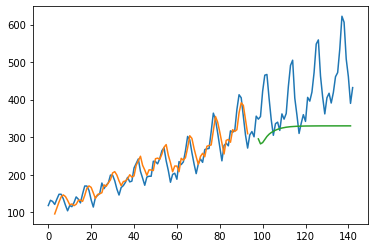

In [5]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [6]:
def R_C_E(y_true, y_pred): 
    return (numpy.sum((y_true - (y_pred))**2)/ numpy.sum(y_true**2)) *100
idx = 0
test_batch = testY.T
pred_batch = testPredict
print(R_C_E(test_batch[:22,:],pred_batch[:22]))
print(R_C_E(test_batch[22:42-1,:],pred_batch[22:42-1]))

5.356476513852445
10.437244148136916
